In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from urllib.parse import quote, unquote
from bs4 import BeautifulSoup

In [85]:
articles = pd.read_csv('wikispeedia_paths-and-graph/articles.tsv', comment='#', delimiter='\t', encoding='utf8', 
                                    names=['article'])
categories = pd.read_csv('wikispeedia_paths-and-graph/categories.tsv', comment='#', delimiter='\t',
                                    names=['article', 'category'])
links = pd.read_csv('wikispeedia_paths-and-graph/links.tsv', comment='#', delimiter='\t', 
                                    names=['article', 'linkTarget'])  
finished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_finished.tsv', comment='#', delimiter='\t', 
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
unfinished_paths = pd.read_csv('wikispeedia_paths-and-graph/paths_unfinished.tsv', comment='#', delimiter='\t',
                                    names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [86]:
# Apply decoding on articles
# Note: article names stored in df are decdoed but with 
# underscores (_) instead of spaces ( )
articles['article'] = articles['article'].apply(unquote)
categories['article'] = categories['article'].apply(unquote)
links = links.applymap(unquote)
links.head(5)

,article,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland


In [87]:
# Set indices
articles.set_index('article', inplace=True)
categories.set_index('article', inplace=True)
finished_paths.set_index('hashedIpAddress', inplace=True)
unfinished_paths.set_index('hashedIpAddress', inplace=True)

In [88]:
# Create df with all paths
paths_combined = pd.concat([finished_paths, unfinished_paths])
paths_combined.head(5)
print(len(finished_paths.index))

51318


In [89]:
# Filter out all paths with <
finished_paths_with_back = finished_paths.loc[finished_paths.path.str.contains('<')]

def get_associated_articles(path):
    article_list = path.split(';')
    index = article_list.index('<')
    return article_list[index-1], article_list[index+1]
    
# Add columns of associated articles before and after <
# TODO: get rid of warnings
finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
    zip(*finished_paths_with_back['path'].map(get_associated_articles))
finished_paths_with_back.head(5)

C:\Users\herma\AppData\Local\Temp\ipykernel_17484\3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \
C:\Users\herma\AppData\Local\Temp\ipykernel_17484\3853467544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_paths_with_back['article1'], finished_paths_with_back['article2'] = \


,timestamp,durationInSec,path,rating,article1,article2
hashedIpAddress,,,,,,
4cb0068c36658716,1248654953,253,14th_century;Time;Science;Nature;Weather;Sunli...,3.0,Sunlight,Sun
0d57c8c57d75e2f5,1283956474,391,14th_century;Renaissance;Empiricism;Nature;Wea...,5.0,Sunlight,Rain
0d57c8c57d75e2f5,1290753904,432,14th_century;Renaissance;Leonardo_da_Vinci;Wat...,NaN,Cloud,<
03dc907932cecfc5,1336436263,387,14th_century;Europe;Republic_of_Ireland;<;<;Eu...,2.0,Republic_of_Ireland,<
46021cc81bd7069a,1343940479,246,14th_century;Time;Physics;<;Day;Sun;Sunlight;U...,NaN,Physics,Day


In [90]:
len(finished_paths_with_back.index)

8995

In [91]:
# Functions for accessing article data
# Return a list containing plaintext content of wikipedia article
def get_plaintext(name):
    file_path = 'plaintext_articles/' + quote(name) + '.txt'
    with open(file_path, encoding='utf-8') as file:
        #first 5 lines are comments and titles 
        lines = file.readlines()[5:] 
        return list(map(str.strip, lines))

# Return prettified html content of wikipedia article
def get_html(name):
    file_path = 'wpcd/wp/' + name[0] + '/' + quote(name) + '.htm'
    with open(file_path) as file:
        html_doc = file.read()
        soup = BeautifulSoup(html_doc, 'html.parser')
        return soup.prettify()

The number of articles is: 4604
The mean number of links is: linkTarget    26.038662
dtype: float64


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

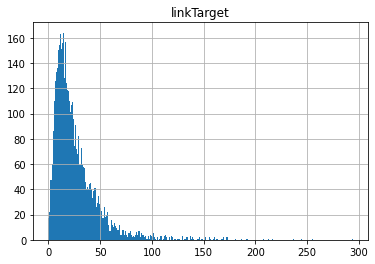

In [98]:
# Exploratory Data Analysis
n_articles = len(articles)
print(f'The number of articles is: {n_articles}')
n_links = links.groupby(['article'])['linkTarget'].count()
articles_with_links = articles.join(n_links).fillna(0)
mean_links = articles_with_links.mean()
print(f'The mean number of links is: {mean_links}')

articles_with_links['linkTarget']
bins = [i for i in range(int(max(articles_with_links['linkTarget'])+1))]
ax = articles_with_links.hist(bins=bins)
plt.show()